In [1]:
import os, glob, pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
from PIL import Image

## Feature extraction
from keras_preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from keras.layers import Dense, Flatten, Input, Activation
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import mixed_precision
import IPython

c:\Users\fcoel\miniconda3\envs\apc-project\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


First step is to generate embeddings for unlabelled data

In [2]:
# Building Training and Validation Dataframes
labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

def dataframer(base_dir, include_unlabelled=False):
    path = []
    label = []
    for img_class in os.listdir(base_dir):
        label_path = os.path.join(base_dir, img_class)
        if img_class in labels:
            for img in os.listdir(label_path):
                path.append(os.path.join(label_path, img))
                label.append(img_class)
    
    if include_unlabelled:
        print("Loading unlabelled data...")
        c = 0
        for tag in os.listdir("../data/seg_pred"):

            img_path = os.path.join("../data/seg_pred", tag)

            if c < 1:
                print(f"Example: {img_path}")
                c += 1

            path.append(img_path)
            label.append('-1') 

    img_data = pd.DataFrame({'Path': path, 'Label': label})
    return img_data

train_base_dir = "../data/seg_train"
validation_base_dir = "../data/seg_test"

train_img_data = dataframer(train_base_dir, include_unlabelled=True)
validation_img_data = dataframer(validation_base_dir)

target_size = (150, 150)


def preprocessing(arr):
    arr = tf.image.rgb_to_grayscale(arr)
    arr = tf.image.resize(arr, target_size)
    return arr

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale = 1/255,
    preprocessing_function=preprocessing
)

validation_datagen = ImageDataGenerator(
    rescale = 1/255
)

# Generating Batches of the Augmented Data:
batch_size = 360

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_img_data,
    x_col="Path",
    y_col="Label",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=False,
    seed=10)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_img_data,
    x_col="Path",
    y_col="Label",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False)

# Build Model
resnet = ResNet50V2(include_top=False, pooling='avg')
resnet.trainable = False # Let's start with frozen resnet weights and train just the dense

# Compile the model
resnet.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])

Loading unlabelled data...
Example: ../data/seg_pred\10004.jpg
Found 21335 validated image filenames belonging to 7 classes.
Found 3000 validated image filenames belonging to 6 classes.


In [3]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
train_labels = le.fit_transform(train_img_data["Label"])
validation_labels = le.transform(validation_img_data["Label"])

cats = le.inverse_transform([0, 1, 2, 3, 4, 5, 6])

with open("../models/semisup_labels.pickle", "wb") as handle:
    labels = {"train": train_labels, "validation": validation_labels, "categorical": cats}
    pickle.dump(labels, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [4]:
cats

array(['-1', 'buildings', 'forest', 'glacier', 'mountain', 'sea',
       'street'], dtype=object)

In [ ]:
def extract_features(model, data_gen):

    features = model.predict(data_gen)

    return features


train_feats = extract_features(resnet, train_generator)
validation_feats = extract_features(resnet, validation_generator)

9/9 [==============================] - 45s 5s/step


In [ ]:
# with open('../models/semisup_embedding_train.pickle', 'wb') as handle:
#     pickle.dump(train_feats, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('../models/semisup_embedding_validation.pickle', 'wb') as handle:
#     pickle.dump(validation_feats, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
with open('../models/semisup_embedding_train.pickle', 'rb') as handle:
    train_feats = pickle.load(handle)

with open('../models/semisup_embedding_validation.pickle', 'rb') as handle:
    validation_feats = pickle.load(handle)

The unlabelled images need to have a virtual label index of -1, as instructed by `sckit-learn`.

At this point, we have all the embeddings stored (only need to load them with the above cell), but we still need to enforce above convetion on label values.

In [6]:
# Correct labelling 
train_labels = train_labels - 1
validation_labels = validation_labels - 1

In [7]:
train_feats.shape

(21335, 2048)

In [8]:
train_labels.shape

(21335,)

In [9]:
validation_feats.shape

(3000, 2048)

In [10]:
validation_labels.shape

(3000,)

Choose only same models used for ensemble:

1. k-Nearest Neighbours
2. Logistic Regression
3. Huber Loss Classifier (SGD + Modified Hubber Loss)

Apply probability calibration, as instructed in the API:
- [Semi-supervised learning](https://scikit-learn.org/stable/modules/semi_supervised.html#id4)
- [Probability calibration](https://scikit-learn.org/stable/modules/calibration.html#calibration)
- [Probability calibration example](https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_multiclass.html#sphx-glr-auto-examples-calibration-plot-calibration-multiclass-py)

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=10, leaf_size=15)

In [15]:
# Remove unlabelled data
to_include_idx = train_labels >= 0
train_labels_cut = train_labels[to_include_idx]
train_feats_cut = train_feats[to_include_idx]

# X1, X2, y1, y2 = train_test_split(train_feats_cut, train_labels_cut, test_size=0.3, random_state=42)
X1, X2, y1, y2 = train_test_split(train_feats, train_labels, test_size=0.2, random_state=42)

# Train without calibration
knn.fit(X1, y1)

# Train with calibration
cal_knn = CalibratedClassifierCV(knn, method="sigmoid", cv="prefit")
cal_knn.fit(X2, y2)

CalibratedClassifierCV(base_estimator=KNeighborsClassifier(leaf_size=15,
                                                           n_neighbors=10),
                       cv='prefit')

In [16]:
knn_proba = knn.predict_proba(validation_feats)
cal_knn_proba = cal_knn.predict_proba(validation_feats)

In [17]:
knn_proba

array([[0.4, 0.6, 0. , ..., 0. , 0. , 0. ],
       [0.2, 0.7, 0. , ..., 0. , 0. , 0.1],
       [0.5, 0.5, 0. , ..., 0. , 0. , 0. ],
       ...,
       [0.3, 0. , 0. , ..., 0.4, 0.3, 0. ],
       [0.6, 0.2, 0. , ..., 0. , 0. , 0.2],
       [0.4, 0.1, 0. , ..., 0. , 0. , 0.5]])

In [18]:
cal_knn_proba

array([[0.35271729, 0.53927168, 0.01322026, ..., 0.02654471, 0.02264508,
        0.01923114],
       [0.29178878, 0.60061778, 0.01112748, ..., 0.02234265, 0.01906034,
        0.03286751],
       [0.43206871, 0.43675306, 0.01605586, ..., 0.03223826, 0.02750221,
        0.02335601],
       ...,
       [0.403742  , 0.01754102, 0.01526393, ..., 0.30979058, 0.20101223,
        0.022204  ],
       [0.6122928 , 0.10358306, 0.02255923, ..., 0.04529625, 0.03864188,
        0.13262892],
       [0.38954032, 0.03379483, 0.01460043, ..., 0.02931593, 0.02500918,
        0.4786165 ]])

Perform semi-supervised training

In [36]:
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier

In [37]:
logreg = SGDClassifier(alpha=0.019323822134521308, loss='log_loss')
huber = SGDClassifier(alpha=0.26007184302607766, loss='modified_huber')
knn = KNeighborsClassifier(leaf_size=15, n_neighbors=10, weights='distance')

cal_huber = CalibratedClassifierCV(huber, method="sigmoid", cv=5)
cal_knn = CalibratedClassifierCV(knn, method="sigmoid", cv=5)

In [38]:
models = [
    logreg,
    cal_huber,
    cal_knn
]

names = ["logistic_reg", "huber_loss", "knn"]

ensemble_model = VotingClassifier(estimators=list(zip(names, models)),
                                  voting="soft", weights=[2, 2, 1])


In [39]:
self_training_model = SelfTrainingClassifier(ensemble_model)

In [40]:
self_training_model.fit(train_feats, train_labels)

SelfTrainingClassifier(base_estimator=VotingClassifier(estimators=[('logistic_reg',
                                                                    SGDClassifier(alpha=0.019323822134521308,
                                                                                  loss='log_loss')),
                                                                   ('huber_loss',
                                                                    CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.26007184302607766,
                                                                                                                        loss='modified_huber'),
                                                                                           cv=5)),
                                                                   ('knn',
                                                                    CalibratedClassifierCV(base_estimator=KNeighborsClassifier(leaf_size=15,
                                                                                                                               n_neighbors=10,
                                                                                                                               weights='distance'),
                                                                                           cv=5))],
                                                       voting='soft',
                                                       weights=[2, 2, 1]))

In [43]:
from sklearn.metrics import f1_score, balanced_accuracy_score

In [52]:
from sklearn.metrics import confusion_matrix

validation_pred = self_training_model.predict(validation_feats)

# Get the confusion matrix
cm = confusion_matrix(validation_labels, validation_pred)

# We will store the results in a dictionary for easy access later
per_class_accuracies = {}

# Calculate the accuracy for each one of our classes
for idx, cls in enumerate(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']):
    # True negatives are all the samples that are not our current GT class (not the current row) 
    # and were not predicted as the current class (not the current column)
    true_negatives = np.sum(np.delete(np.delete(cm, idx, axis=0), idx, axis=1))
    
    # True positives are all the samples of our current GT class that were predicted as such
    true_positives = cm[idx, idx]
    
    # The accuracy for the current class is ratio between correct predictions to all predictions
    per_class_accuracies[cls] = (true_positives + true_negatives) / np.sum(cm)

In [53]:
per_class_accuracies

{'buildings': 0.9796666666666667,
 'forest': 0.9966666666666667,
 'glacier': 0.9346666666666666,
 'mountain': 0.9383333333333334,
 'sea': 0.9786666666666667,
 'street': 0.98}

In [54]:
total = 0
for acc in per_class_accuracies.values():
    total += acc
total /= len(per_class_accuracies)
total

0.968

Repeat analysis but with ensemble without unlabeled data

In [48]:
with open("../models/embedding_train.pickle", "rb") as handle:
    train_feats_sup = pickle.load(handle)

with open("../models/embedding_validation.pickle", "rb") as handle:
    validation_feats_sup = pickle.load(handle)

with open("../models/labels.pickle", "rb") as handle:
    labels_dict = pickle.load(handle)

train_labels_sup = labels_dict["train"]
validation_labels_sup = labels_dict["validation"]
categories_sup = labels_dict["categorical"]

In [49]:
logreg = SGDClassifier(alpha=0.019323822134521308, loss='log_loss')
huber = SGDClassifier(alpha=0.26007184302607766, loss='modified_huber')
knn = KNeighborsClassifier(leaf_size=15, n_neighbors=10, weights='distance')

models = [
    logreg,
    huber,
    knn
]

names = ["logistic_reg", "huber_loss", "knn"]

ensemble_model = VotingClassifier(estimators=list(zip(names, models)),
                                  voting="soft", weights=[2, 2, 1])

In [50]:
ensemble_model.fit(train_feats_sup, train_labels_sup)

VotingClassifier(estimators=[('logistic_reg',
                              SGDClassifier(alpha=0.019323822134521308,
                                            loss='log_loss')),
                             ('huber_loss',
                              SGDClassifier(alpha=0.26007184302607766,
                                            loss='modified_huber')),
                             ('knn',
                              KNeighborsClassifier(leaf_size=15, n_neighbors=10,
                                                   weights='distance'))],
                 voting='soft', weights=[2, 2, 1])

In [55]:
validation_pred_sup = ensemble_model.predict(validation_feats_sup)

# Get the confusion matrix
cm = confusion_matrix(validation_labels_sup, validation_pred_sup)

# We will store the results in a dictionary for easy access later
per_class_accuracies_sup = {}

# Calculate the accuracy for each one of our classes
for idx, cls in enumerate(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']):
    # True negatives are all the samples that are not our current GT class (not the current row) 
    # and were not predicted as the current class (not the current column)
    true_negatives = np.sum(np.delete(np.delete(cm, idx, axis=0), idx, axis=1))
    
    # True positives are all the samples of our current GT class that were predicted as such
    true_positives = cm[idx, idx]
    
    # The accuracy for the current class is ratio between correct predictions to all predictions
    per_class_accuracies_sup[cls] = (true_positives + true_negatives) / np.sum(cm)

In [56]:
per_class_accuracies_sup

{'buildings': 0.9756666666666667,
 'forest': 0.9963333333333333,
 'glacier': 0.9363333333333334,
 'mountain': 0.942,
 'sea': 0.978,
 'street': 0.979}

In [57]:
total = 0
for acc in per_class_accuracies_sup.values():
    total += acc
total /= len(per_class_accuracies_sup)
total

0.9678888888888889

In [65]:
from sklearn.metrics import classification_report

report_ensemble = classification_report(validation_labels, ensemble_model.predict(validation_feats), target_names=cats[1:])
report_self_training = classification_report(validation_labels, self_training_model.predict(validation_feats), target_names=cats[1:])

In [66]:
print(report_ensemble)

              precision    recall  f1-score   support

   buildings       0.90      0.94      0.92       437
      forest       0.98      0.99      0.99       474
     glacier       0.87      0.77      0.82       553
    mountain       0.81      0.88      0.84       525
         sea       0.94      0.94      0.94       510
      street       0.95      0.93      0.94       501

    accuracy                           0.90      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.90      0.90      0.90      3000



In [67]:
print(report_self_training)

              precision    recall  f1-score   support

   buildings       0.93      0.93      0.93       437
      forest       0.98      1.00      0.99       474
     glacier       0.89      0.74      0.81       553
    mountain       0.78      0.90      0.84       525
         sea       0.93      0.94      0.94       510
      street       0.94      0.94      0.94       501

    accuracy                           0.90      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.90      0.90      3000



Explore more of self-training 

In [69]:
self_training_labels = self_training_model.transduction_

In [79]:
no_label = np.argwhere(train_labels < 0)

new_labels = self_training_labels[no_label].flatten()

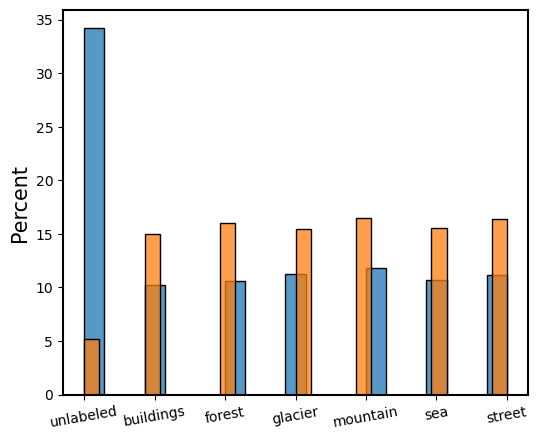

In [129]:
import seaborn as sns
from IPython.display import display_png

fig, ax = plt.subplots(figsize=(6, 5))

complete_labels = np.concatenate((train_labels, validation_labels))
expanded_labels = np.concatenate((self_training_labels, validation_labels))

sns.histplot(train_labels, stat="percent", ax=ax)
sns.histplot(self_training_labels, stat="percent", ax=ax)


tick_labels = ["unlabeled"] + list(cats[1:])
ax.set_xticks(range(-1, 6), tick_labels, rotation=10)


plt.savefig("../images/self_training_data_dist.png", dpi=500)


In [132]:
unlabeled_idx = np.argwhere(self_training_labels < 0)

array([[14034],
       [14036],
       [14039],
       ...,
       [21325],
       [21328],
       [21330]], dtype=int64)

In [137]:
unlabeled_img_path = train_img_data["Path"].iloc[unlabeled_idx.flatten()]

unlabeled_img_path

14034    ../data/seg_pred\10004.jpg
14036    ../data/seg_pred\10012.jpg
14039    ../data/seg_pred\10021.jpg
14052    ../data/seg_pred\10066.jpg
14054    ../data/seg_pred\10073.jpg
                    ...            
21318     ../data/seg_pred\9950.jpg
21319     ../data/seg_pred\9954.jpg
21325     ../data/seg_pred\9975.jpg
21328     ../data/seg_pred\9986.jpg
21330     ../data/seg_pred\9988.jpg
Name: Path, Length: 1110, dtype: object

In [152]:
import seaborn_image as isns

# Visualize the data
images = []
for path in unlabeled_img_path:
    sample_img = Image.open(path)
    sample_img = sample_img.resize((150, 150))
    sample_arr = np.array(sample_img)
    images.append(sample_arr)

print(len(images))


1110


In [165]:
sample_size = 25
random_sample = np.random.choice(np.arange(len(images)), size=sample_size)
random_sample

array([ 702,  314,  876,  815, 1061,  867,  265,   76,  931, 1016, 1004,
        378,  366,  862,  529,  443,  861,  482,  717, 1087,  468,  979,
       1036, 1033,  314])

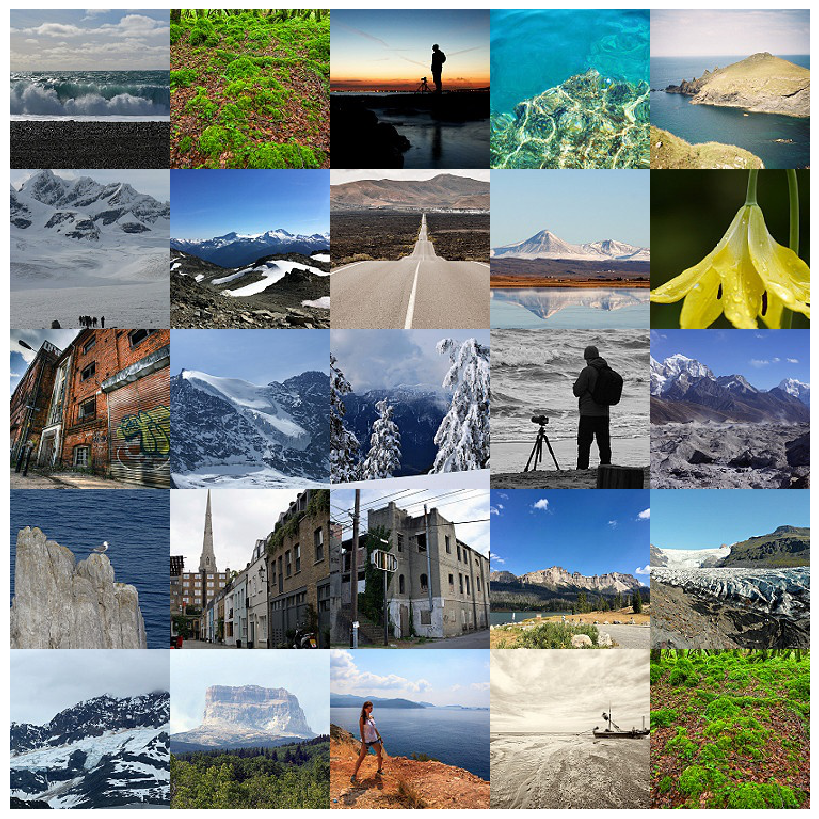

In [166]:
my_images = [images[i] for i in random_sample]

fig, ax = plt.subplots(5, 5, figsize=(8, 8))

c = 0
for i in range(5):
    for j in range(5):
        ca = ax[i, j]
        im = my_images[c]
        im = np.flipud(im)
        ca.imshow(im, aspect="equal")
        ca.set_axis_off()
        c += 1

fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
